# Soft Actor Critic

#### Off Policy 

## Environment

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt

In [2]:
# Select Lunar Lander v3 as environment
env = gym.make("LunarLander-v3", continuous=False, render_mode="rgb_array")

# Get number of actions from gym action space
n_actions = int(env.action_space.n)
print(f"Number of possible actions: {n_actions}")
print("""Actions:
0: do nothing
1: fire left orientation engine
2: fire main engine
3: fire right orientation engine
""")

# Get the number of state observations
state, info = env.reset()
n_observations = len(state)
print(f"Number of state observations: {n_observations}")

print("""State (Observation Space):
x, y
vel_x, vel_y
angle, angle_vel
left_leg_touching, right_leg_touching
      """)
print("Current state: ", state)

print("""Units of the state are as follows:
      ‘x’: (units), ‘y’: (units), 
      ‘vx’: (units/second), ‘vy’: (units/second), 
      ‘angle’: (radians), ‘angular velocity’: (radians/second)
      """)

Number of possible actions: 4
Actions:
0: do nothing
1: fire left orientation engine
2: fire main engine
3: fire right orientation engine

Number of state observations: 8
State (Observation Space):
x, y
vel_x, vel_y
angle, angle_vel
left_leg_touching, right_leg_touching
      
Current state:  [-0.00771761  1.4071156  -0.78173155 -0.16912368  0.00894964  0.17707406
  0.          0.        ]
Units of the state are as follows:
      ‘x’: (units), ‘y’: (units), 
      ‘vx’: (units/second), ‘vy’: (units/second), 
      ‘angle’: (radians), ‘angular velocity’: (radians/second)
      


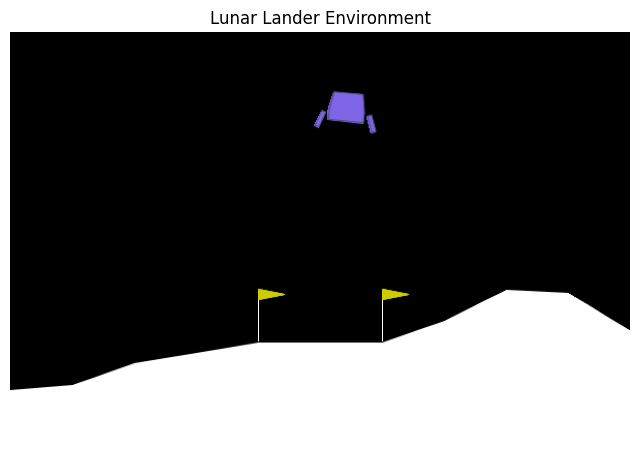

In [3]:
# Reset the environment to get the initial state
state, info = env.reset()

for i in range(50):
    env.step(action=0)
# Render the environment to get an RGB image
frame = env.render()

# Plot the image
plt.figure(figsize=(8, 6))
plt.imshow(frame)
plt.axis("off")
plt.title("Lunar Lander Environment")
plt.show()

## Plotting Helper

In [4]:
import matplotlib

In [5]:
# set up matplotlib
is_ipython = "inline" in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()


def plot_metrics(episode_durations, rewards, show_result=False, save_path=None):
    # Create a horizontal figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5), dpi=100)
    fig.suptitle("Training Metrics" if not show_result else "Results", fontsize=16)

    # Plot Episode Durations
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    axes[0].set_title("Episode Durations")
    axes[0].set_xlabel("Episode")
    axes[0].set_ylabel("Duration")
    axes[0].plot(durations_t.numpy(), label="Duration")

    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        axes[0].plot(means.numpy(), label="100-Episode Avg", linestyle="--")

    axes[0].legend()

    # Plot Rewards
    rewards_t = torch.tensor(rewards, dtype=torch.float)
    axes[1].set_title("Rewards")
    axes[1].set_xlabel("Episode")
    axes[1].set_ylabel("Reward")
    axes[1].plot(rewards_t.numpy(), label="Reward")

    if len(rewards_t) >= 100:
        reward_means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        reward_means = torch.cat((torch.zeros(99), reward_means))
        axes[1].plot(reward_means.numpy(), label="100-Episode Avg", linestyle="--")

    axes[1].legend()

    # Adjust layout and save/show
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Add space for the suptitle
    if save_path:
        plt.savefig(save_path + ".png", dpi=300)
        print(f"Metrics figure saved to {save_path}")

    if "get_ipython" in globals():
        if not show_result:
            display.clear_output(wait=True)
            display.display(fig)
        else:
            display.display(fig)
    else:
        plt.show()

    plt.close(fig)

## ReplayBuffer

In [6]:
from collections import namedtuple, deque
from typing import List, Deque
import random

# Define the type of the Transition tuple
Transition = namedtuple("Transition", ("state", "action", "next_state", "reward", "done"))


# ReplayMemory class with strong type hints
class ReplayMemory:
    def __init__(self, capacity: int):
        # The deque stores Transition objects
        self.memory: Deque[Transition] = deque([], maxlen=capacity)

    def push(self, state: float, action: int, next_state: float, reward: float, done: bool) -> None:
        """Save a transition"""
        self.memory.append(Transition(state, action, next_state, reward, int(done)))

    def sample(self, batch_size: int) -> List[Transition]:
        """Sample a batch of transitions"""
        return random.sample(self.memory, batch_size)

    def __len__(self) -> int:
        """Return the current size of the memory"""
        return len(self.memory)

In [7]:
import torch
from torch.optim import Adam, Optimizer
from torch.distributions import Categorical
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from models import MLP
from typing import Tuple

import pandas as pd
from datetime import datetime
from numpy.typing import NDArray

In [8]:
torch.manual_seed(1)

## NN Weight Updates

In [9]:
def soft_update(target: nn.Module, source: nn.Module, tau: float) -> None:
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)


def hard_update(target: nn.Module, source: nn.Module) -> None:
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(param.data)

## Policy Network

In [10]:
class PolicyNetwork(nn.Module):
    """
    Neural network for policy-based reinforcement learning.

    Architecture:
    - Input layer: Accepts `num_inputs` features representing the state.
    - Hidden layers: Two fully connected layers with 256 units each and ReLU activation for non-linearity.
    - Output layer: Produces `num_outputs`, representing action space size or logits.

    Args:
        num_inputs (int): Number of input features (state size).
        num_outputs (int): Number of output features (action size).

    Methods:
        forward(x): Propagates the input through the network.
    """

    def __init__(self, num_inputs: int, num_outputs: int) -> None:
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(num_inputs, 256), nn.ReLU(), nn.Linear(256, 256), nn.ReLU(), nn.Linear(256, num_outputs)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the network.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, num_inputs).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, num_outputs).
        """
        return self.net(x)

## Q Network

In [11]:
class QNetwork(nn.Module):
    def __init__(self, num_observations: int, num_actions: int):
        super(QNetwork, self).__init__()
        self.q1 = MLP(input_dim=num_observations, output_dim=num_actions)
        self.q2 = MLP(input_dim=num_observations, output_dim=num_actions)

    def forward(self, state: torch.Tensor):
        x1 = self.q1(state)
        x2 = self.q2(state)

        return x1, x2

## Soft-Actor-Critic

In [12]:
class SoftActorCriticAgent:
    def __init__(
        self,
        actor_network: nn.Module,
        critic_network: nn.Module,
        target_critic_network: nn.Module,
        discount_factor_gamma: float = 0.99,
        soft_update_rate_tau: float = 0.05,
        exploration_temperature_alpha: float = 0.2,
        learning_rate: float = 3e-3,
    ) -> None:
        self.discount_factor_gamma = discount_factor_gamma
        self.soft_update_rate_tau = soft_update_rate_tau
        self.exploration_temperature_alpha = exploration_temperature_alpha

        self.actor_network = actor_network
        self.critic_network = critic_network
        self.target_critic_network = target_critic_network

        self.policy_optimizer = Adam(self.actor_network.parameters(), lr=learning_rate)
        self.critic_optimizer = Adam(self.critic_network.parameters(), lr=learning_rate)

    def sample_stochastic_action_with_log_prob(self, state: torch.Tensor) -> Tuple[int, torch.Tensor]:
        """
        Stochastically selects an action and computes its log-probability for discrete SAC.

        Args:
            state (torch.Tensor): The current state.

        Returns:
            Tuple[int, torch.Tensor]:
                - action (int): The chosen action index.
                - log_prob (torch.Tensor): The log-probability of the chosen action.
        """
        action_logits = self.actor_network(state)  # Get logits from the policy network
        action_distribution = Categorical(logits=action_logits)  # Create a categorical distribution
        sampled_action = action_distribution.sample()  # Sample an action
        log_prob = action_distribution.log_prob(sampled_action)  # Compute log-probability
        return int(sampled_action.item()), log_prob

    def sample_greedy_action(self, state: torch.Tensor) -> int:
        """
        Selects the most likely action deterministically for evaluation.

        Args:
            state (torch.Tensor): The current state.

        Returns:
            int: The action index with the highest probability.
        """
        action_logits = self.actor_network(state)  # Get logits from the policy network
        greedy_action = torch.argmax(action_logits).item()  # Select the action with the highest logit
        return int(greedy_action)

    def estimate_policy_values(self, states: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Estimates policy values: action probabilities, log probabilities, and minimum Q-values.

        Categorical.probs (Tensor): event probabilities

        Categorical.logits (Tensor): event log probabilities (unnormalized)

        Args:
            states (torch.Tensor): Batch of states for estimation.

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
                - Action probabilities
                - Log probabilities of actions
                - Minimum Q-values from the critics
        """
        # Get action logits and distribution
        action_logits = self.actor_network(states)
        action_distribution = Categorical(logits=action_logits)
        action_probs = action_distribution.probs  # Action probabilities
        log_pis = action_distribution.logits  # Log-probabilities

        # Evaluate Q-values for all actions
        q1_values, q2_values = self.critic_network(states)
        min_q_values = torch.min(q1_values, q2_values)  # Minimum Q-values

        return action_probs, log_pis, min_q_values

    def calculate_policy_loss(
        self, action_probs: torch.Tensor, log_pis: torch.Tensor, min_q_values: torch.Tensor
    ) -> torch.Tensor:
        """
        Computes the policy loss.

        Args:
            action_probs (torch.Tensor): Action probabilities.
            log_pis (torch.Tensor): Log probabilities of actions.
            min_q_values (torch.Tensor): Minimum Q-values from critics.

        Returns:
            torch.Tensor: Mean policy loss.
        #### Mathematical Equation:
        For a state $$s$$, the policy loss is:$$
        \mathcal{L}_{\pi} = \mathbb{E}_{s \sim D}\left[ \sum_{a} \pi(a|s) \left( \alpha \log \pi(a|s) - Q(s, a) \right) \right]
        $$
        """
        # Weighted loss computation
        weighted_loss = (action_probs * (self.exploration_temperature_alpha * log_pis - min_q_values)).sum(dim=1)
        policy_loss = weighted_loss.mean()

        return policy_loss

    def estimate_q_values(
        self, states: torch.Tensor, actions: torch.Tensor, next_states: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Estimates current and target Q-values.

        Args:
            states (torch.Tensor): Current states.
            actions (torch.Tensor): Actions taken in the current states.
            next_states (torch.Tensor): Next states.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Current Q-values and target Q-values.
        """
        # Current Q-values
        q1_values, q2_values = self.critic_network(states)
        q1_current = q1_values.gather(1, actions).squeeze(1)
        q2_current = q2_values.gather(1, actions).squeeze(1)

        # Target Q-values
        with torch.no_grad():
            next_action_logits = self.actor_network(next_states)
            next_action_distribution = Categorical(logits=next_action_logits)
            next_action_probs = next_action_distribution.probs  # type:ignore
            next_action_log_probs = next_action_distribution.logits  # type:ignore

            next_q1_values, next_q2_values = self.critic_network(next_states)
            next_q_values = torch.min(next_q1_values, next_q2_values)  # type:ignore

            target_q_values = torch.sum(
                next_action_probs * (next_q_values - self.exploration_temperature_alpha * next_action_log_probs), dim=1
            )
        return q1_current, q2_current, target_q_values

    def calculate_q_value_loss(
        self,
        q1_current: torch.Tensor,
        q2_current: torch.Tensor,
        target_q_values: torch.Tensor,
        rewards: torch.Tensor,
        done: torch.Tensor,
    ) -> torch.Tensor:
        """
        Computes the Q-value loss.

        Args:
            q1_current (torch.Tensor): Q1 values for current actions.
            q2_current (torch.Tensor): Q2 values for current actions.
            target_q_values (torch.Tensor): Target Q-values.
            rewards (torch.Tensor): Rewards received after taking actions.
            done (torch.Tensor): Terminal flags for the episodes.
            gamma (float): Discount factor.

        Returns:
            torch.Tensor: Combined Q-value loss for both critics.
        #### Mathematical Equation:
        For a state $$s$$, action $$a$$, reward $$r$$, next state $$s'$$, and discount factor $$\gamma$$, the Q-value loss is:$$
        \mathcal{L}_Q = \mathbb{E}_{(s, a, r, s') \sim D}\left[ \left(Q_{\theta_1}(s, a) - y\right)^2 + \left(Q_{\theta_2}(s, a) - y\right)^2 \right]
        $$

        where:
        $$
        y = r + \gamma (1 - \text{done}) \mathbb{E}_{a' \sim \pi}\left[ Q(s', a') - \alpha \log \pi(a'|s') \right]
        $$
        """
        # Target Q-value for Bellman update
        q_value_target = rewards + self.discount_factor_gamma * (1 - done) * target_q_values

        # MSE loss
        qf1_loss = F.mse_loss(q1_current, q_value_target)
        qf2_loss = F.mse_loss(q2_current, q_value_target)

        # Combined loss
        qf_loss = qf1_loss + qf2_loss
        return qf_loss

    def optimize(
        self,
        states_batch: torch.Tensor,
        actions_batch: torch.Tensor,
        rewards_batch: torch.Tensor,
        next_states_batch: torch.Tensor,
        done_batch: torch.Tensor,
    ) -> Tuple[float, float]:
        """
        Performs an optimization step for the policy and critic networks using data from the replay buffer.

        Args:
            states, actions, rewards, next_states, and done.

        Returns:
            Tuple[float, float]: Policy loss and Q-value loss as Python floats.
        """

        # 1. Q-Value Loss Estimation and Optimization
        q1_current, q2_current, target_q_values = self.estimate_q_values(
            states=states_batch,
            actions=actions_batch,
            next_states=next_states_batch,
        )

        q_value_loss = self.calculate_q_value_loss(
            q1_current=q1_current,
            q2_current=q2_current,
            target_q_values=target_q_values,
            rewards=rewards_batch,
            done=done_batch,
        )

        # Update critic network
        self.critic_optimizer.zero_grad()
        q_value_loss.backward()  # type:ignore
        self.critic_optimizer.step()  # type:ignore

        # 2. Policy Loss Estimation and Optimization
        action_probs, log_pis, min_q_values = self.estimate_policy_values(states_batch)
        policy_loss = self.calculate_policy_loss(action_probs, log_pis, min_q_values)

        # Update policy network
        self.policy_optimizer.zero_grad()
        policy_loss.backward()  # type:ignore
        self.policy_optimizer.step()  # type:ignore

        # 3. Soft Update for Target Network
        with torch.no_grad():
            soft_update(self.target_critic_network, self.critic_network, self.soft_update_rate_tau)

        return policy_loss.item(), q_value_loss.item()

## Neural Network Initialization

In [13]:
# Policy
policy_network = PolicyNetwork(n_observations, n_actions)

# Q Network Q1 and Q2
q_network = QNetwork(n_observations, n_actions)

# Target Q Network Q1_target and Q2_target
q_network_target = QNetwork(n_observations, n_actions)

# Hard update target initially so that Q networks have same weights in the beginning
hard_update(q_network_target, q_network)


# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Using device: ", device)

device = torch.device("cpu")

# Send all NNs to device you have available and want to use
policy_network.to(device)
q_network.to(device)
q_network_target.to(device)

Using device:  mps


QNetwork(
  (q1): MLP(
    (fc_1): Linear(in_features=8, out_features=128, bias=True)
    (fc_2): Linear(in_features=128, out_features=4, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (q2): MLP(
    (fc_1): Linear(in_features=8, out_features=128, bias=True)
    (fc_2): Linear(in_features=128, out_features=4, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

## Hyperparameters

In [14]:
discount_factor_gamma = 0.99
soft_update_rate_tau = 0.05
exploration_temperature_alpha = 0.2
batch_size = 256

In [15]:
soft_actor_critic_agent = SoftActorCriticAgent(
    actor_network=policy_network,
    critic_network=q_network,
    target_critic_network=q_network_target,
    discount_factor_gamma=discount_factor_gamma,
    soft_update_rate_tau=soft_update_rate_tau,
    exploration_temperature_alpha=exploration_temperature_alpha,
)

### Initialize Replay Memory

In [16]:
replay_memory = ReplayMemory(10000)

In [17]:
# Fill replay memory to minimum
for i in range(batch_size):
    state, _ = env.reset()
    action = 0
    next_state, reward, terminated, truncated, _ = env.step(action)

    # Store the experience in replay memory
    replay_memory.push(state, action, next_state, reward, terminated or truncated)

print(len(replay_memory))

256


## Trainer

In [18]:
# def record_data_and_train_on_a_batch(
#     env: gym.Env,
#     agent: SoftActorCriticAgent,
#     device: torch.device,
#     batch_size: int = 256,
#     updates_per_episode_recorded: int = 5,
# ) -> dict:
#     global global_track_steps_per_episode, global_track_reward_per_episode

#     total_rewards = []
#     total_steps = 0

#     # Reset the environment for a new episode
#     state, _ = env.reset()

#     episode_reward = 0.0
#     episode_steps = 0
#     episode_rewards = []

#     while True:
#         # Convert state to tensor and send it to the device
#         state_tensor = torch.Tensor(state).to(device)

#         # Select an action using the policy
#         action, log_prob = agent.sample_stochastic_action_with_log_prob(state=state_tensor)

#         # Take the selected action in the environment
#         next_state, reward, terminated, truncated, _ = env.step(action)

#         episode_steps += 1

#         # Store log-probability and reward
#         episode_rewards.append(reward)

#         # Update cumulative reward and state
#         episode_reward += reward
#         state = next_state
#         total_steps += 1

#         # Break if the episode ends
#         if terminated or truncated:
#             break

#     global_track_steps_per_episode.append(episode_steps)
#     global_track_reward_per_episode.append(episode_reward)

#     plot_metrics(global_track_steps_per_episode, global_track_reward_per_episode)

#     for i in range(updates_per_episode_recorded):
#         # 1. Sample a batch
#         state_batch, action_batch, reward_batch, next_state_batch, done_signal_batch = replay_memory.sample(batch_size)
#         policy_loss, q_values_loss = agent.optimize(state_batch, action_batch, reward_batch, next_state_batch, done_signal_batch)

#     # Return metrics to track training progress
#     metrics = {
#         "batch_reward": sum(total_rewards) / batch_size,  # Average reward per episode
#         "total_steps": total_steps // batch_size,
#         "policy_loss": policy_loss,
#         "q_value_loss": q_values_loss,
#     }

#     return metrics

In [19]:
from typing import Dict, Optional, List


def record_data_and_train_on_a_batch(
    env: gym.Env,
    agent: SoftActorCriticAgent,
    replay_memory: ReplayMemory,  # Ensure ReplayMemory is passed as a parameter
    device: torch.device,
    batch_size: int = 256,
    updates_per_episode_recorded: int = 5,
) -> Dict[str, Optional[float]]:
    """
    Records data from an episode and performs training on sampled batches from replay memory.

    Args:
        env (gym.Env): The Gym environment.
        agent (SoftActorCriticAgent): The SAC agent.
        replay_memory (ReplayMemory): The replay memory buffer.
        device (torch.device): The device to run computations on.
        batch_size (int, optional): Number of samples per batch. Defaults to 256.
        updates_per_episode_recorded (int, optional): Number of optimization steps per episode. Defaults to 5.
        global_track_steps_per_episode (List[int], optional): Tracker for steps per episode.
        global_track_reward_per_episode (List[float], optional): Tracker for rewards per episode.

    Returns:
        Dict[str, Optional[float]]: Metrics for tracking training progress.
    """
    global global_track_steps_per_episode, global_track_reward_per_episode

    episode_reward = 0.0
    episode_steps = 0

    # Reset the environment for a new episode
    reset_result = env.reset()
    state = reset_result[0] if isinstance(reset_result, tuple) else reset_result

    while True:
        # Convert state to tensor and send it to the device
        state_tensor = torch.tensor(state, dtype=torch.float32).to(device)

        # Select an action using the policy
        with torch.no_grad():
            action, log_prob = agent.sample_stochastic_action_with_log_prob(state=state_tensor)

        # Convert action to numpy array for env.step
        action_np = action.cpu().numpy() if isinstance(action, torch.Tensor) else action

        # Take the selected action in the environment
        state, reward, terminated, truncated, _ = env.step(action_np)

        episode_steps += 1
        episode_reward += reward

        # Store transition in replay memory
        replay_memory.push(state, action_np, next_state, reward, terminated or truncated)

        "state", "action", "next_state", "reward", "done"

        # Update state
        state = next_state

        # Break if the episode ends
        if terminated or truncated:
            break

    # Update global trackers
    global_track_steps_per_episode.append(episode_steps)
    global_track_reward_per_episode.append(episode_reward)

    # Plot metrics (ensure plot_metrics is defined elsewhere)
    plot_metrics(global_track_steps_per_episode, global_track_reward_per_episode)

    policy_loss_over_number_of_updates = 0.0
    q_value_loss_over_number_of_updates = 0.0

    # Perform optimization steps
    for _ in range(updates_per_episode_recorded):
        if len(replay_memory) < batch_size:
            break  # Not enough samples to train

        # Sample a batch
        transitions = replay_memory.sample(batch_size)
        batch = Transition(*zip(*transitions))

        # Helper function to convert a list of elements to a tensor
        def to_tensor(element_list, dtype=torch.float32):
            return torch.tensor(element_list, dtype=dtype, device=device)

        # Convert each component of the batch to tensors
        # Assuming states and next_states are already in a suitable format (e.g., numpy arrays or lists)
        state_batch = torch.stack([to_tensor(state) for state in batch.state])
        action_batch = torch.stack([to_tensor(action, dtype=torch.int64) for action in batch.action]).unsqueeze(1)
        reward_batch = torch.stack([to_tensor(reward) for reward in batch.reward]).unsqueeze(
            1
        )  # Shape: (batch_size, 1)
        next_state_batch = torch.stack([to_tensor(next_state) for next in batch.next_state])
        done_batch = to_tensor(batch.done, dtype=torch.float32).unsqueeze(1)  # Shape: (batch_size, 1)

        # Optimize the agent and retrieve losses
        policy_loss, q_value_loss = agent.optimize(
            state_batch, action_batch, reward_batch, next_state_batch, done_batch
        )

        policy_loss_over_number_of_updates += policy_loss
        q_value_loss_over_number_of_updates += q_value_loss

    # Calculate average reward per step
    average_reward = episode_reward / episode_steps if episode_steps > 0 else 0.0

    # Compile metrics
    metrics = {
        "average_reward": average_reward,
        "total_steps": episode_steps,
        "policy_loss": policy_loss_over_number_of_updates / updates_per_episode_recorded,
        "q_value_loss": q_value_loss_over_number_of_updates / updates_per_episode_recorded,
    }

    return metrics

In [20]:
from datetime import datetime

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [21]:
def train(
    env: gym.Env,
    agent: SoftActorCriticAgent,
    replay_memory: ReplayMemory,
    device: torch.device,
    max_episodes: int = 500,
    reward_threshold: float = 200.0,
    rolling_window: int = 50,
    batch_size: int = 256,
    updates_per_episode_recorded: int = 5,
    save_dir: str = "output",
) -> Tuple[List[float], List[float], List[int]]:
    """
    Trains the Soft Actor-Critic agent in the given environment.

    Args:
        env (gym.Env): The Gym environment.
        agent (SoftActorCriticAgent): The SAC agent.
        replay_memory (ReplayMemory): The replay memory buffer.
        device (torch.device): The device to run computations on.
        max_episodes (int, optional): Maximum number of episodes to train. Defaults to 500.
        reward_threshold (float, optional): Reward threshold for solving the environment. Defaults to 200.0.
        rolling_window (int, optional): Number of episodes to consider for rolling average. Defaults to 50.
        batch_size (int, optional): Number of samples per batch for training. Defaults to 256.
        updates_per_episode_recorded (int, optional): Number of optimization steps per episode. Defaults to 5.
        save_dir (str, optional): Directory to save the trained models. Defaults to "output".

    Returns:
        Tuple[List[float], List[float], List[int]]: Histories of rewards, losses, and steps per episode.
    """
    import os

    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Initialize trackers
    rewards_history: List[float] = []
    loss_history: List[float] = []
    steps_history: List[int] = []

    best_average_reward: float = -np.inf  # Initialize to negative infinity

    # Initialize global trackers for metrics
    global_track_steps_per_episode: List[int] = []
    global_track_reward_per_episode: List[float] = []

    # Generate a timestamp for model saving
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    for episode in range(1, max_episodes + 1):
        # Record data and perform training
        metrics = record_data_and_train_on_a_batch(
            env=env,
            agent=agent,
            replay_memory=replay_memory,
            device=device,
            batch_size=batch_size,
            updates_per_episode_recorded=updates_per_episode_recorded,
        )

        # Collect metrics
        rewards_history.append(metrics.get("average_reward", 0.0))
        loss_history.append(metrics.get("policy_loss", 0.0) or metrics.get("q_value_loss", 0.0))
        steps_history.append(metrics.get("total_steps", 0))

        # Calculate the average reward over the last 'rolling_window' episodes
        if len(rewards_history) >= rolling_window:
            avg_rolling_reward = np.mean(rewards_history[-rolling_window:])
        else:
            avg_rolling_reward = np.mean(rewards_history)

        # Print metrics every 5 episodes
        if episode % 5 == 0:
            current_loss = metrics.get("policy_loss", 0.0)
            current_steps = metrics.get("total_steps", 0)
            print(
                f"Episode {episode}: Average Reward (last {min(rolling_window, len(rewards_history))} episodes): {avg_rolling_reward:.2f}, "
                f"Policy Loss: {current_loss:.4f}, Steps: {current_steps}"
            )

        # Convergence condition: Check if the rolling average exceeds the reward threshold
        if len(rewards_history) >= rolling_window and avg_rolling_reward >= reward_threshold:
            print(
                f"Environment solved in {episode} episodes! "
                f"Average reward over the last {rolling_window} episodes: {avg_rolling_reward:.2f}"
            )
            # Optionally, save the final model
            final_filename = os.path.join(save_dir, f"actor_critic_policy_final_{timestamp}.pth")
            torch.save(agent.policy_network.state_dict(), final_filename)
            print(f"Final model saved as: {final_filename}")
            break

        # Save the model if the current average reward is the best so far
        if avg_rolling_reward > best_average_reward:
            best_average_reward = avg_rolling_reward

            # Create a filename that includes the episode number and timestamp
            filename = os.path.join(save_dir, f"actor_critic_policy_ep_{episode}_bs_{batch_size}_{timestamp}.pth")

            # Save the policy network with the dynamically generated filename
            torch.save(agent.actor_network.state_dict(), filename)

            print(f"Episode: {episode}, Average reward: {avg_rolling_reward:.2f}. Model saved as: {filename}")

        # Optionally, plot metrics periodically or at the end
        # if episode % 50 == 0:
        #     plot_metrics(global_track_steps_per_episode, global_track_reward_per_episode)

    env.close()

    return rewards_history, loss_history, steps_history

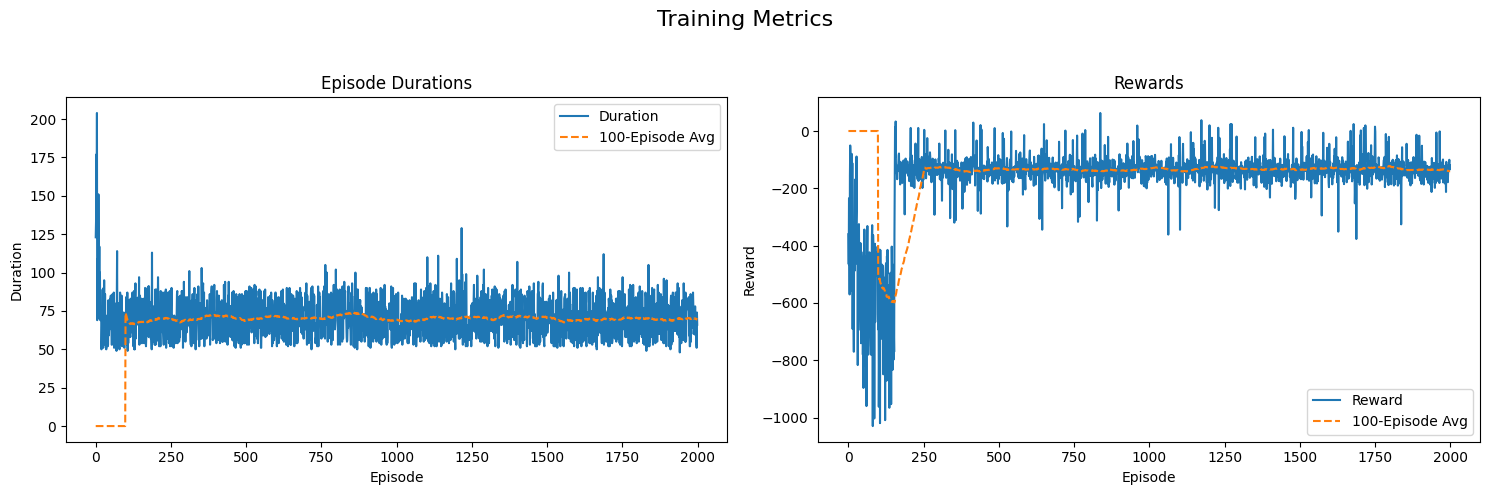

Episode 2000: Average Reward (last 50 episodes): -1.99, Policy Loss: 3185.2129, Steps: 66


In [22]:
max_episodes = 2000
reward_threshold = 200.0

global_track_steps_per_episode = []
global_track_reward_per_episode = []

rewards_history, loss_history, steps_history = train(
    max_episodes=max_episodes,
    reward_threshold=reward_threshold,
    batch_size=batch_size,
    agent=soft_actor_critic_agent,
    device=device,
    replay_memory=replay_memory,
    env=env,
)